In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import scipy

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [4]:
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

In [5]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [6]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

In [7]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [8]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [9]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

In [10]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [11]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [12]:
df2['artistID'].min()

1

In [13]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [14]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [15]:
vals[-1]

2098

In [16]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [17]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [18]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [19]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [20]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [21]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [22]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [23]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [24]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [25]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [26]:
df2['weight'].max()

352698

In [27]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


In [28]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [29]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [30]:
df3['friendID'].max()

2098

In [31]:
df3['friendID'].nunique()

1892

In [32]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [33]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [34]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [35]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [36]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [37]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [38]:
df3['friendID'].max()

1891

In [39]:
df3.isnull().values.any()

False

In [40]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [41]:
df5 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.csv")
df5.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


Our last two dataframes seem exactly the same. Let's check this before we delete anything.

In [42]:
def checkequality(A, B):

    df11 = A.sort_index(axis=1)
    df11 = df11.sort_values(df11.columns.tolist()).reset_index(drop=True)

    df22 = B.sort_index(axis=1)
    df22 = df22.sort_values(df22.columns.tolist()).reset_index(drop=True)
    return (df11 == df22).values.all()

a = checkequality(df4, df5)
print (a)

True


Two of our files are exactly the same. We can delete one of these accordingly.

In [43]:
del df5

In [44]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4["artistID"] = df4["artistID"].apply(lambda x: str(x-1))

df4['artistID'] = df4['artistID'].astype(int)
df4['userID'] = df4['userID'].astype(int)

In [45]:
xyz =  np.array(df4['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [46]:
unique_list = list(set(vals))
unique_list.sort()
print(unique_list[-1])

usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

18743


17631

In [47]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [48]:
s = df4['artistID']

df4['artistID'] = s.map(diction)

In [49]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

In [50]:
df4

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,11288,4,1,7,2010
186475,1891,11288,292,1,5,2010
186476,1891,11288,2087,1,7,2010
186477,1891,11288,2801,1,5,2010


In [51]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

In [52]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")
tags.isnull().values.any()
tags['artistID'].max()

12522

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [53]:
df['name'].value_counts()

MALICE MIZER                        1
BEAT!BEAT!BEAT!                     1
ãƒˆã‚¯ãƒžãƒ«ã‚·ãƒ¥ãƒ¼ã‚´            1
Thao with The Get Down Stay Down    1
ãƒªã‚¢ãƒ»ãƒ‡ã‚£ã‚¾ãƒ³               1
                                   ..
Innerpartysystem                    1
Helia                               1
Devil Sold His Soul                 1
Nevea Tears                         1
Grzegorz Tomczak                    1
Name: name, Length: 17632, dtype: int64

In [54]:
df1['tagID'].value_counts()

1        1
8368     1
8359     1
8360     1
8361     1
        ..
4059     1
4060     1
4061     1
4062     1
12648    1
Name: tagID, Length: 11946, dtype: int64

After initial observation, I feel the timestamp dataframe is of little use to me and hence disregard it. As per the readme file we have 1892 users and 17632 artists in our data.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [61]:
played.drop(columns=['pictureURL'], inplace=True)

In [63]:
mean = played['played'].mean()
print("The mean number of times a user listens to a song is: " + str(mean))

The mean number of times a user listens to a song is: 745.2439300256372


In [64]:
median = played['played'].median()
print("The median number of times a user listens to a song is: " + str(median))

The median number of times a user listens to a song is: 260.0


<AxesSubplot:>

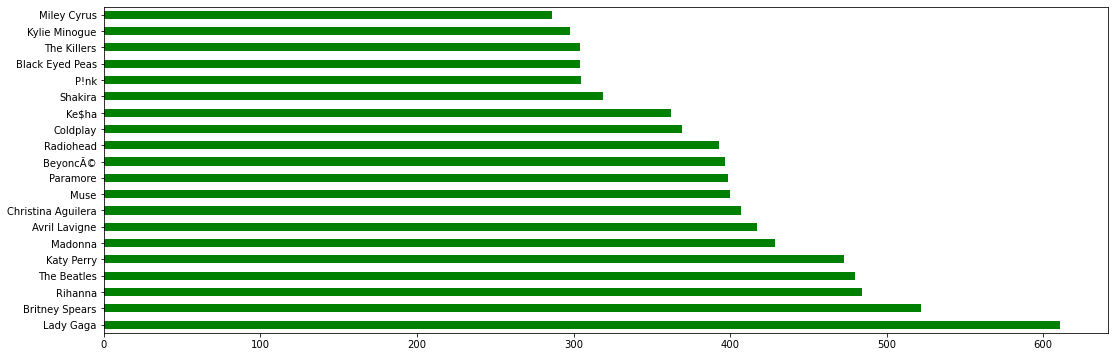

In [65]:
played['name'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

<AxesSubplot:xlabel='played'>

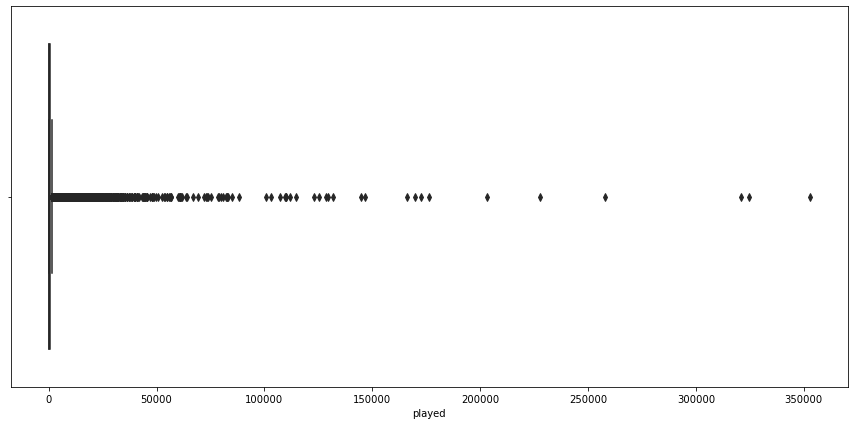

In [66]:
plt.figure(figsize=[15,7])
sns.boxplot(x=played['played'], color=".25")

There appears to be quite a lot of outliers here in the played column. Some users have obviously listened to their songs far more times than the average. We double check our values for mean and median earlier and can confirm there are quite a few outliers here.

In [67]:
played.describe()

,artID,userID,artistID,played
count,92834.000000,92834.000000,92834.000000,92834.00000
mean,3235.736724,944.222483,3235.736724,745.24393
std,4197.216910,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,0.000000,1.00000
25%,430.000000,470.000000,430.000000,107.00000
50%,1237.000000,944.000000,1237.000000,260.00000
75%,4266.000000,1416.000000,4266.000000,614.00000
max,17631.000000,1891.000000,17631.000000,352698.00000


In [69]:
grouped_multiple = played.groupby(['artistID', 'name']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [70]:
artdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [71]:
artdf

,artistID,name,mean,med,max,sum
283,283,Britney Spears,4584.559387,1000.5,131733,2393140
66,66,Depeche Mode,4614.567376,567.0,352698,1301308
83,83,Lady Gaga,2113.563011,590.0,114672,1291387
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405
492,492,Paramore,2414.659148,417.0,227829,963449
...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1
16239,16239,Gosling,1.000000,1.0,1,1


In [72]:
pt2 = artdf.head(20)

<AxesSubplot:title={'center':'Biggest artists by no of listens'}, xlabel='Artist', ylabel='Listens (millions)'>

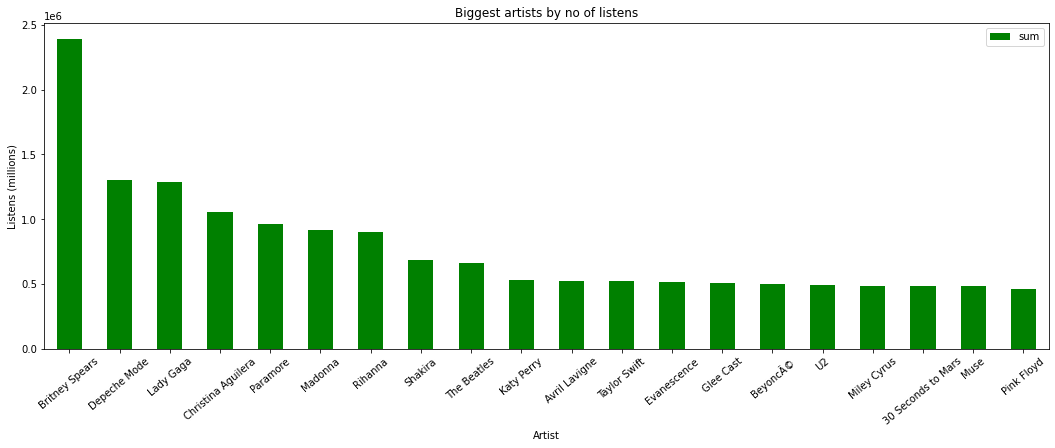

In [73]:
pt2.plot.bar(x = 'name', y = 'sum', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='Listens (millions)', title='Biggest artists by no of listens')

In [74]:
grouped_multiple = played.groupby(['userID']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [75]:
userdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [76]:
pt3 = userdf.head(20)

<AxesSubplot:title={'center':'Users by highest number of listens'}, xlabel='User', ylabel='Listens'>

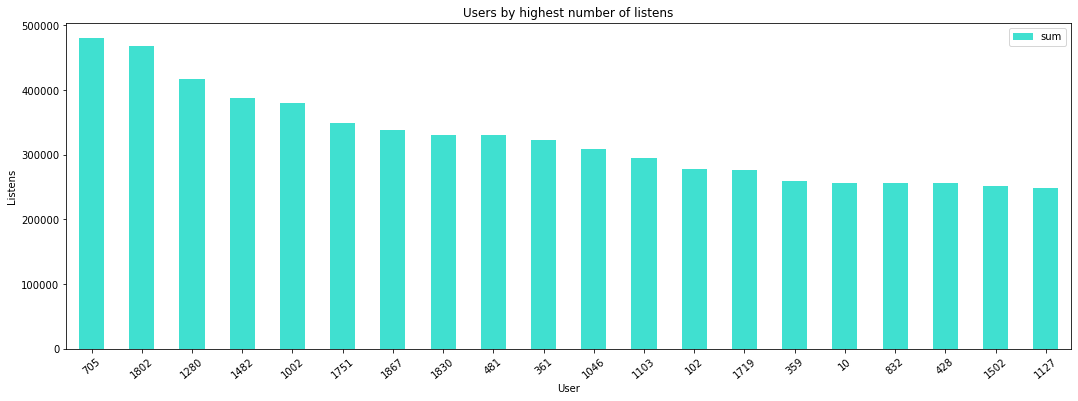

In [77]:
pt3.plot.bar(x = 'userID', y = 'sum', rot = 40, figsize=(18, 6), color='turquoise', xlabel='User', ylabel='Listens', title='Users by highest number of listens')

In [78]:
artdf['mean']

283      4584.559387
66       4614.567376
83       2113.563011
286      2600.503686
492      2414.659148
            ...     
16522       1.000000
13713       1.000000
13712       1.000000
16239       1.000000
16241       1.000000
Name: mean, Length: 17632, dtype: float64

In [79]:
played.shape

(92834, 6)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

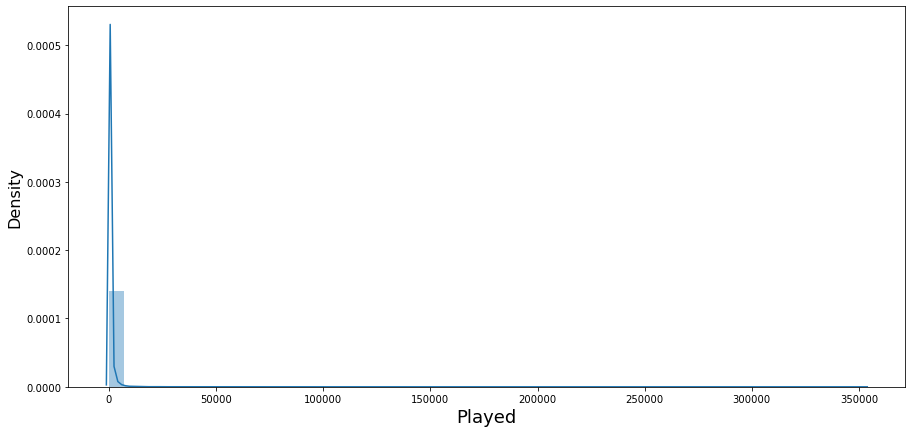

In [80]:
plt.figure(figsize=[15,7])
sns.distplot(played['played'])
plt.xlabel('Played', fontsize=18)
plt.ylabel('Density', fontsize=16)

The majority of values seem around the 1k or less mark. There are a lot of outlier values however going as far as 350,000 for the most extreme values. This confirms our earlier boxplot looking at these values in a clear manner.

In [81]:
xyz = pd.DataFrame(played['name'].value_counts())

In [82]:
xyz = xyz.reset_index()

In [83]:
xyz.rename(columns={'index': 'name', 'name': 'unique'}, inplace=True)

In [84]:
xyz

,name,unique
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
...,...,...
17627,Karmina,1
17628,Alexandre Desplat & Aaron Zigman,1
17629,Burning Brides,1
17630,ozzy,1


In [85]:
merged_df = artdf.merge(xyz, how = 'inner', on = ['name', 'name'])

In [86]:
merged_df

,artistID,name,mean,med,max,sum,unique
0,283,Britney Spears,4584.559387,1000.5,131733,2393140,522
1,66,Depeche Mode,4614.567376,567.0,352698,1301308,282
2,83,Lady Gaga,2113.563011,590.0,114672,1291387,611
3,286,Christina Aguilera,2600.503686,739.0,176133,1058405,407
4,492,Paramore,2414.659148,417.0,227829,963449,399
...,...,...,...,...,...,...,...
17627,16522,K-Precise,1.000000,1.0,1,1,1
17628,13713,ZÃœNDER,1.000000,1.0,1,1,1
17629,13712,Evil Masquerade,1.000000,1.0,1,1,1
17630,16239,Gosling,1.000000,1.0,1,1,1


In [87]:
percent = []
val = merged_df['unique']
total = played['userID'].nunique()
percent = []
for i in range(len(val)):
    y = val[i] / total
    percent.append(y)
    #print(y)

In [88]:
percent = np.array(percent)
artdf['Percentage'] = percent.tolist()

In [89]:
artdf

,artistID,name,mean,med,max,sum,Percentage
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888
...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529
16239,16239,Gosling,1.000000,1.0,1,1,0.000529


In [90]:
artdf['unique'] = merged_df['unique'].values

In [91]:
artdf

,artistID,name,mean,med,max,sum,Percentage,unique
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899,522
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049,282
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939,611
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116,407
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888,399
...,...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529,1
16239,16239,Gosling,1.000000,1.0,1,1,0.000529,1


In [92]:
artdf['Percentage'] = artdf['Percentage'].multiply(100)

In [93]:
artdf = artdf.sort_values(by=['Percentage'], ascending=False)

<AxesSubplot:title={'center':'Percentage of users who listen to most popular artists'}, xlabel='Artist', ylabel='% of unique users who listen'>

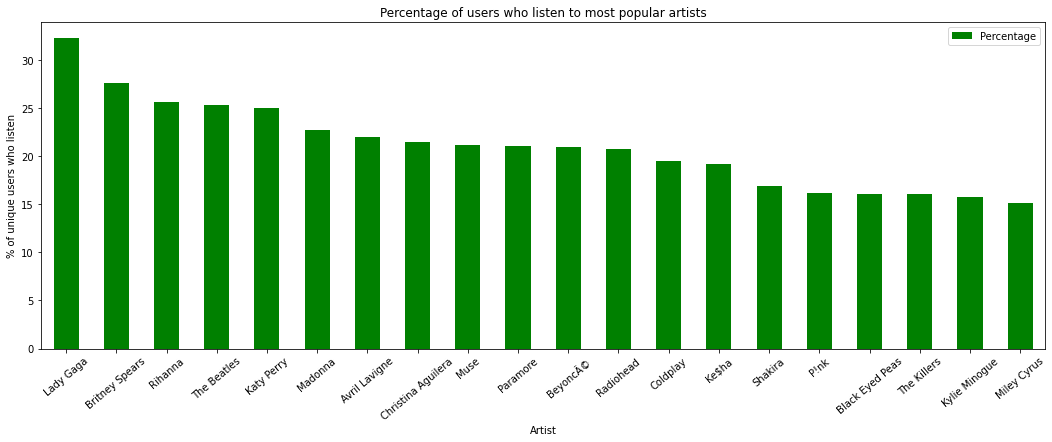

In [94]:
pt2 = artdf.head(20)
pt2.plot.bar(x = 'name', y = 'Percentage', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='% of unique users who listen', title='Percentage of users who listen to most popular artists')

In [95]:
values = [1, 2, 3, 4, 5]
for i in range(len(values)):
    x = len(artdf[artdf['Percentage'] <= values[i]])
    print("The percentage of artists with " + str(values[i]) + "% or less users listening to them is " + str(x) + ".")

The percentage of artists with 1% or less users listening to them is 16794.
The percentage of artists with 2% or less users listening to them is 17200.
The percentage of artists with 3% or less users listening to them is 17350.
The percentage of artists with 4% or less users listening to them is 17430.
The percentage of artists with 5% or less users listening to them is 17497.


We can tell on the whole of the 17632 artists that there are actually very few who are listened to by a wide audience. There are less than 1000 artists who have more than 1% of users listening to them. This means our data is probably leaned very heavily towards the most popular artists such as Britney Spears or Lady Gaga as per our barchart above.

In [96]:
z = played[['name', 'artistID']]

In [97]:
z = z.drop_duplicates()

I was going to try to incorporate the tags as part of my recommender system but as per above I seem to lose data just by the shape and even looking at artistID 1 we see this ID occurs three times in our played data and only twice in our tagged dataset. This is porbably due to the fact the users left no tags on this. We also have some improper values for tags as per above such as "better than lady gaga" and "#NAME?" which aren't going to add any information to our data. If we choose a subset of tags and take out values such as these that aren't as common or add any information we could work with this then. However, this would mean trimming our dataset down further. With less data to work with this might negatively impact the effectiveness of our recommender system.

In [98]:
df4[df4['artistID'] == 1]

,userID,artistID,tagID
3251,37,1,30
3252,37,1,127
3253,37,1,575
21145,211,1,61
26470,247,1,30
31456,303,1,30
31457,303,1,179
31458,303,1,575
66247,649,1,14
66248,649,1,233


This confirms that user 34 does not leave a tag on this artist's work. This is why we lose the rows we do when we try to incorporate the tags data into the listened data. We will disregard this for now.

<AxesSubplot:>

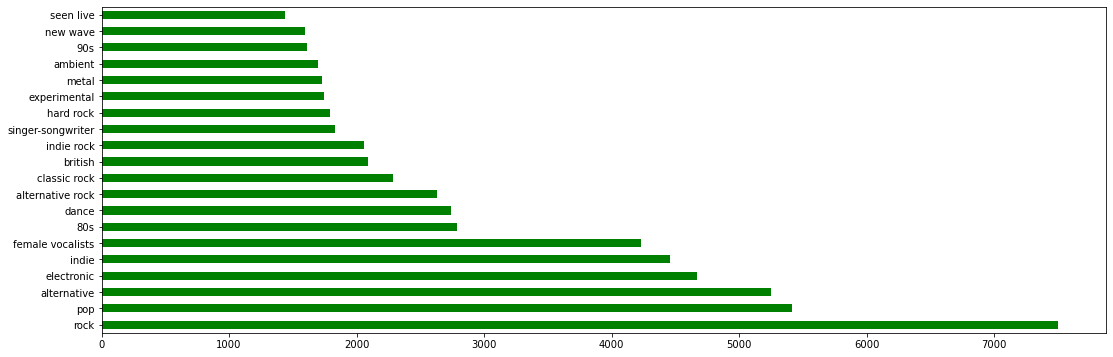

In [99]:
# Let's check most popular tags
tags['tagValue'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

# Sparse Representation of Played matrix

In [100]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
    matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
    num_plays = len(M.nonzero()[1]) # Number of times any artist has been interacted with
    sparsity = 100 * (1 - float(num_plays / matrix_size))
    return sparsity

## Normalising our played column
Next, one of the crucial aspects of our recommender system would be dealing with our played column. With such a diverse number of values from the range of 0 to over 350,000 we would have to deal with these appropriately. Our system would not be able to handle values of such a high nature and when I tried to run this I would get very high train errors and "nan" values for test error. I looked at a variety of different ways to normalize this value as a result and I would only incorporate two of these into my dataframe. I looked at capping any values above the 2,000 mark in our played column at 2,000 but decided against this method. As a result the methods I looked at were:

##### 1) Simple Normalization - normalizing all values based off the highest value in the "played" column.

##### 2) User based Normalization - grouping our played column by users and normalizing each user based off their own max value. I implemented this as a column called "playedUserNorm". This had the best results and was the column I implemented below.

##### 3) Play Count Scaled - here I would take each value in the column and take it away from the minimum value in the column. I would then divide this by the max value of the column minus the minimum value. I implemented this with the column "playCountScaled".

##### 4) Robust Scaling method - here we would scale each feature of the data set by subtracting the median and then dividing by the interquartile range. I tried this method but the results were poor and implementing it took a long time to run.


In [101]:
sm = played['played'].groupby(played['userID']).max()
artss = np.array(played['userID'])
playzz = np.array(played['played'])
#artss[-1]
newnorm = []
for i in range(len(playzz)):
    index = artss[i]
    val = playzz[i] / sm[index]
    newnorm.append(val)

In [102]:
newnorm = np.array(newnorm)

#add newnorm array as new column in DataFrame
played['playedUserNorm'] = newnorm.tolist()

In [103]:
played['playedUserNorm'].max()

1.0

In [104]:
pc = played.played
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

played = played.assign(playCountScaled=play_count_scaled)

In [105]:
# !!! here is our 1) simple normalisation

# played["playBasicNorm"] = played["played"] / played["played"].max()

In [106]:
# played['playCountScaled'].equals(played['playBasicNorm'])

In [107]:
played.head()

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428


In [108]:
# !!! here is our attempt at robust scaling as per 4) 

#newcol = []
#pl = np.array(played['played'])
#for i in range(len(pl)):
#    val = (pl[i] - played['played'].median())  / (played['played'].quantile(0.75) - played['played'].quantile(0.25))
#    newcol.append(val)

In [109]:
#newcol = np.array(newcol)

#add newnorm array as new column in DataFrame
#played['playedRobust'] = newcol.tolist()

In [110]:
played.dtypes

name                object
url                 object
artID                int64
userID               int64
artistID             int64
played               int64
playedUserNorm     float64
playCountScaled    float64
dtype: object

In [111]:
def build_rating_sparse_tensor(ratings_df):
  # ========================= Complete this section ============================
    indices = ratings_df[['userID', 'artID']].values
    values = ratings_df['playedUserNorm'].values
  # ============================================================================

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(played.userID.unique()), len(played.artID.unique())])

In [112]:
len(played.userID.unique())

1892

In [113]:
played.shape[0]

92834

In [114]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    predictions = tf.reduce_sum(
    tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) * tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Building Model

In [115]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations = 100, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# Build and Run the Model

In [116]:
from sklearn.model_selection import train_test_split
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
    #train_ratings, test_ratings = train_test_split(ratings, test_size=0.5)
    train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [117]:
def split_dataframe(df, holdout_fraction=0.3):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [118]:
xyz = played[['userID', 'artID', 'playedUserNorm']]

 iteration 1000: train_error=0.031877, test_error=0.690488

[{'train_error': 0.031876694, 'test_error': 0.690488}]

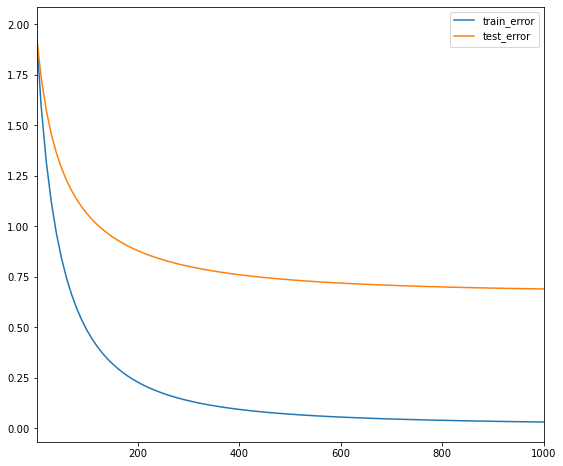

In [119]:
model = build_model(xyz,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

I tried to build my model but the high values for listens was giving me errors like so "InvalidArgumentError: indices[4073] = 2077 is not in [0, 1892)". 

This was why I changed the artist and user ID's to 1.) start from zero and 2.) increment by 1 until the length of unique values - 1. I had to normalise my weights then as I kept returning nan values for train and test errors above.

In [120]:
played.head(6)

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428
5,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,303,1,3466,1.000000,0.009824


In [121]:
#played[played["played"] > 2000]["played"] = 2000

In [122]:
#indexes = played[played["played"] > 2000].index

In [123]:
#played.iloc[indexes,5] = 2000

In [124]:
#played.head()

# Inspect Embeddings

In [125]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [126]:
from IPython import display
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  df[df['name'].str.contains(title_substring)].index.values
  titles = df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artID"][artistID], model.embeddings["artID"],
      measure)
  score_key = measure + ' score'
  df7 = pd.DataFrame({
      score_key: list(scores),
      'names': df['name'],
  })
  display.display(df7.sort_values([score_key], ascending=False).head(k))

In [213]:
artist_grp = ['Lady Gaga', 'The Killers', 'Black Eyed Peas', 'Rihanna', 'Gwen Stefani', 'Eva Simons']
for art in range(len(artist_grp)):
    artist_neighbors(reg_model, artist_grp[art], DOT)
    artist_neighbors(reg_model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
83,11.103067,Lady Gaga
283,3.499162,Britney Spears
282,2.953031,Rihanna
673,2.692652,Glee Cast
294,2.404880,Katy Perry
460,2.171704,Ke$ha


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
10902,0.709674,Arnaldo & Alexandre
12340,0.663540,Dark Schneider
2523,0.661657,Lolene
11545,0.645646,Vic Chesnutt
2896,0.638426,Lloyd Banks


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
223,1.865926,The Killers
184,1.842693,Muse
167,1.689320,Placebo
221,1.514154,The Beatles
492,1.473475,Paramore
148,1.360624,Radiohead


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
176,0.833619,Keane
1506,0.830150,The Fratellis
511,0.772357,Korn
710,0.770412,Kaiser Chiefs
3390,0.769422,Goo Goo Dolls


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
83,1.170658,Lady Gaga
282,1.100062,Rihanna
283,0.941246,Britney Spears
45,0.846957,Duran Duran
289,0.825011,BeyoncÃ©
49,0.790980,Kylie Minogue


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
322,0.862687,David Guetta
532,0.829874,Maroon 5
65,0.792239,Dido
284,0.784871,Jordin Sparks
460,0.776843,Ke$ha


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
282,5.098111,Rihanna
283,3.421446,Britney Spears
83,2.953031,Lady Gaga
251,2.137954,Mariah Carey
201,2.079055,Arctic Monkeys
294,2.034652,Katy Perry


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
308,0.757422,Ciara
460,0.709241,Ke$ha
322,0.692464,David Guetta
321,0.677580,Chris Brown
5030,0.668925,Uffie


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
283,1.135920,Britney Spears
83,0.931769,Lady Gaga
61,0.752138,Madonna
282,0.682909,Rihanna
673,0.629930,Glee Cast
286,0.629511,Christina Aguilera


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
288,0.853515,Leona Lewis
284,0.846443,Jordin Sparks
317,0.827932,The Saturdays
529,0.827873,Sophie Ellis-Bextor
292,0.826881,Lily Allen


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,dot score,names
283,0.393801,Britney Spears
61,0.210908,Madonna
282,0.204790,Rihanna
83,0.150894,Lady Gaga
201,0.150663,Arctic Monkeys
294,0.137613,Katy Perry


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,cosine score,names
1432,1.000000,Eva Simons
303,0.617974,Danity Kane
1626,0.598677,The D.O.C.
17160,0.588859,Yarema
17280,0.567701,Astronautas
783,0.550474,ThalÃ­a


While our cosine score results provide very strong recommendations using the dot product model here produces mediocre results at best. This also factors in that the dot product is a very popular method for recommender systems and as a result we will need to incorporate further methods to get better results. We will attempt to use a regularized matrix. The key point of this being that regularization is to enforce conditions, for example sparsity or smoothness, that can produce stable predictive functions and in our case improve our model.

# Regularized Matrix

In [128]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(xyz)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.032404, test_error_observed=0.050876, observed_loss=0.032404, regularization_loss=0.016966, gravity_loss=0.000824

[{'train_error_observed': 0.032404482, 'test_error_observed': 0.050875794},
 {'observed_loss': 0.032404482,
  'regularization_loss': 0.016966244,
  'gravity_loss': 0.00082396425}]

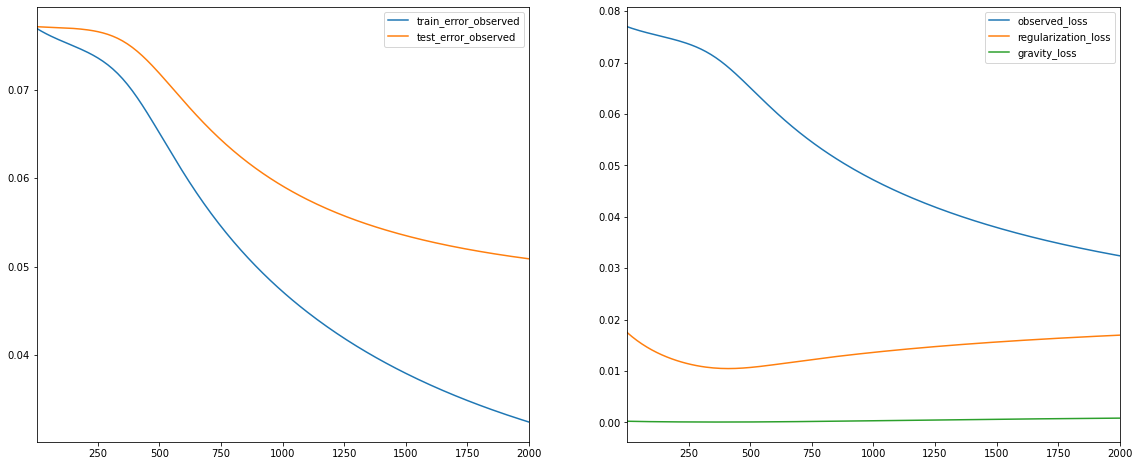

In [129]:
reg_model, u, v  = build_regularized_model(xyz, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

Let's test our model on a group of artists to get a better understanding of it's recommendations.

In [214]:
for art in range(len(artist_grp)):
    artist_neighbors(reg_model, artist_grp[art], DOT)
    artist_neighbors(reg_model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
83,11.103067,Lady Gaga
283,3.499162,Britney Spears
282,2.953031,Rihanna
673,2.692652,Glee Cast
294,2.404880,Katy Perry
460,2.171704,Ke$ha


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
10902,0.709674,Arnaldo & Alexandre
12340,0.663540,Dark Schneider
2523,0.661657,Lolene
11545,0.645646,Vic Chesnutt
2896,0.638426,Lloyd Banks


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
223,1.865926,The Killers
184,1.842693,Muse
167,1.689320,Placebo
221,1.514154,The Beatles
492,1.473475,Paramore
148,1.360624,Radiohead


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
176,0.833619,Keane
1506,0.830150,The Fratellis
511,0.772357,Korn
710,0.770412,Kaiser Chiefs
3390,0.769422,Goo Goo Dolls


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
83,1.170658,Lady Gaga
282,1.100062,Rihanna
283,0.941246,Britney Spears
45,0.846957,Duran Duran
289,0.825011,BeyoncÃ©
49,0.790980,Kylie Minogue


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
322,0.862687,David Guetta
532,0.829874,Maroon 5
65,0.792239,Dido
284,0.784871,Jordin Sparks
460,0.776843,Ke$ha


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
282,5.098111,Rihanna
283,3.421446,Britney Spears
83,2.953031,Lady Gaga
251,2.137954,Mariah Carey
201,2.079055,Arctic Monkeys
294,2.034652,Katy Perry


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
308,0.757422,Ciara
460,0.709241,Ke$ha
322,0.692464,David Guetta
321,0.677580,Chris Brown
5030,0.668925,Uffie


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
283,1.135920,Britney Spears
83,0.931769,Lady Gaga
61,0.752138,Madonna
282,0.682909,Rihanna
673,0.629930,Glee Cast
286,0.629511,Christina Aguilera


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
288,0.853515,Leona Lewis
284,0.846443,Jordin Sparks
317,0.827932,The Saturdays
529,0.827873,Sophie Ellis-Bextor
292,0.826881,Lily Allen


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,dot score,names
283,0.393801,Britney Spears
61,0.210908,Madonna
282,0.204790,Rihanna
83,0.150894,Lady Gaga
201,0.150663,Arctic Monkeys
294,0.137613,Katy Perry


Nearest neighbors of : Eva Simons.
[Found more than one matching artist. Other candidates: Afrojack ft. Eva Simons]


,cosine score,names
1432,1.000000,Eva Simons
303,0.617974,Danity Kane
1626,0.598677,The D.O.C.
17160,0.588859,Yarema
17280,0.567701,Astronautas
783,0.550474,ThalÃ­a


These are actually very good recommendations produced by our recommender system based off each users unique normalised values based on the highest listened value they obtained. 

# Alternate method - Recommender based on Neural Network

Here we will try to implement another type of recommender system and see does it produce equally as good of results. Our alternate model is based off a neural network to make predictions for users based off listening numbers. As per this article on [Investopedia](https://www.investopedia.com/terms/n/neuralnetwork.asp#:~:text=A%20neural%20network%20is%20a,way%20the%20human%20brain%20operates.&text=Neural%20networks%20can%20adapt%20to,to%20redesign%20the%20output%20criteria.) , a neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. This will help us uncover any listening patterns found in our data by users.

In [131]:
sub = played[['userID', 'artID', 'playedUserNorm']]

In [132]:
sub.head()

,userID,artID,playedUserNorm
0,31,0,0.055775
1,256,0,0.065394
2,729,0,0.025149
3,130,1,0.150902
4,240,1,0.154315


In [133]:
train, test = train_test_split(sub, test_size=0.3, train_size=0.7)

In [134]:
train.head()

,userID,artID,playedUserNorm
25330,485,469,0.021292
80227,560,8278,0.683168
57736,1171,2264,0.359970
4192,484,101,0.713873
81362,615,8869,0.145833


In [135]:
test.head()

,userID,artID,playedUserNorm
3111,1062,78,0.014665
504,1269,39,0.057882
51015,467,1518,0.005650
62695,1218,2957,0.017020
41412,25,996,0.370370


In [136]:
n_users = len(sub.userID.unique())
n_users

1892

In [137]:
n_artist = len(sub.artID.unique())
n_artist

17632

In [138]:
# creating artist embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, user_vec])
model = Model([user_input, artist_input], prod)
model.compile('adam', 'mean_squared_error')

In [139]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [140]:
model.evaluate([test.userID, test.artID], test.playedUserNorm)

11.735790786056269

In [141]:
predictions = model.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[1.4817643] 0.01466544454628781
[2.7192962] 0.05788243753370483
[0.5453392] 0.005649717514124294
[3.475547] 0.0170196671709531
[1.1129295] 0.37037037037037035
[3.1147027] 0.08296943231441048
[2.512576] 0.11005225945281279
[0.38393092] 0.03197026022304833
[0.98757935] 0.04582977512097922
[1.2260777] 0.07501476668635558


[None, None, None, None, None, None, None, None, None, None]

# Neural Network

In [142]:
# creating book embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artists")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([artist_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, artist_input], out)
model2.compile('adam', 'mean_squared_error')

In [143]:
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [144]:
model2.evaluate([test.userID, test.artID], test.playedUserNorm)

1861768.685029263

In [145]:
predictions = model2.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[366.5604] 0.01466544454628781
[241.45642] 0.05788243753370483
[285.5112] 0.005649717514124294
[332.88687] 0.0170196671709531
[387.1468] 0.37037037037037035
[2239.0317] 0.08296943231441048
[605.0779] 0.11005225945281279
[290.03625] 0.03197026022304833
[367.624] 0.04582977512097922
[363.21695] 0.07501476668635558


[None, None, None, None, None, None, None, None, None, None]

# Visualizing Embeddings

In [146]:
# Extract embeddings
artist_em = model.get_layer("Artist-Embedding")
artist_em_weights = artist_em.get_weights()[0]

In [147]:
artist_em_weights[:5]

array([[ 0.04103883, -0.2710777 ,  0.28193265,  0.01121594, -0.21962109],
       [ 0.42227656, -0.44878516,  0.46648487, -0.12221594, -0.40105212],
       [-0.18079431, -0.13342255,  0.1553544 , -0.3333101 , -0.00778394],
       [ 0.150518  , -0.19249448,  0.1592992 ,  0.12258738, -0.12723902],
       [ 0.2513393 , -0.21272472,  0.1814355 , -0.22018886, -0.13649407]],
      dtype=float32)

<AxesSubplot:>

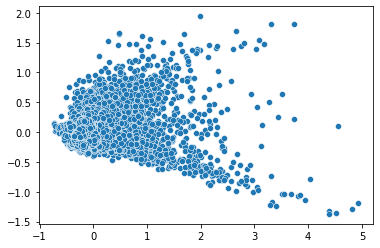

In [148]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [149]:
artist_em_weights = artist_em_weights / np.linalg.norm(artist_em_weights, axis = 1).reshape((-1, 1))
artist_em_weights[0][:10]
np.sum(np.square(artist_em_weights[0]))

1.0

<AxesSubplot:>

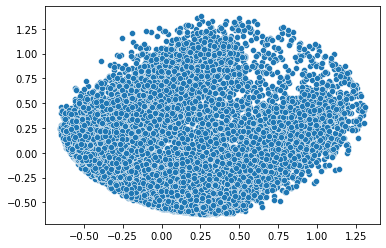

In [150]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [151]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(artist_em_weights)

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17633 samples in 0.039s...
[t-SNE] Computed neighbors for 17633 samples in 1.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17633
[t-SNE] Computed conditional probabilities for sample 2000 / 17633
[t-SNE] Computed conditional probabilities for sample 3000 / 17633
[t-SNE] Computed conditional probabilities for sample 4000 / 17633
[t-SNE] Computed conditional probabilities for sample 5000 / 17633
[t-SNE] Computed conditional probabilities for sample 6000 / 17633
[t-SNE] Computed conditional probabilities for sample 7000 / 17633
[t-SNE] Computed conditional probabilities for sample 8000 / 17633
[t-SNE] Computed conditional probabilities for sample 9000 / 17633
[t-SNE] Computed conditional probabilities for sample 10000 / 17633
[t-SNE] Computed conditional probabilities for sample 11000 / 17633
[t-SNE] Computed conditional probabilities for sample 12000 / 17633
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:>

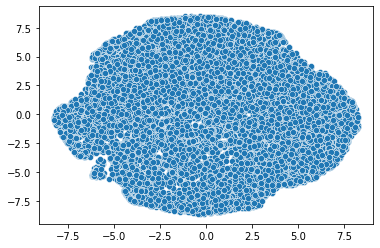

In [152]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Making Recommendations

In [153]:
# Creating dataset for making recommendations for a user
artist_data = np.array(list(set(sub.artID)))
artist_data

array([    0,     1,     2, ..., 17629, 17630, 17631])

Let's pick a random user to generate recommendations for. We will go with the user of ID equalling 83.

In [154]:
user = np.array([83 for i in range(len(artist_data))])
user

array([83, 83, 83, ..., 83, 83, 83])

In [155]:
predictions = model.predict([user, artist_data])

predictions = np.array([a[0] for a in predictions])

recommended_artist_ids = (predictions).argsort()[:5]

recommended_artist_ids

array([8131, 8135, 8324, 2754, 8139], dtype=int64)

In [156]:
predictions[recommended_artist_ids]

array([-1.1105492 , -1.0870131 , -1.0431927 , -0.9887378 , -0.98679465],
      dtype=float32)

In [157]:
df[df['artID'].isin(recommended_artist_ids)]

,name,url,pictureURL,artID
2754,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754
8131,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131
8135,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135
8139,Luctus,http://www.last.fm/music/Luctus,http://userserve-ak.last.fm/serve/252/8688989.jpg,8139
8324,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324


Let's check does our recommender produce novel results. In our recommender system as mentioned earlier it can be hard to gauge good recommenders in a formal manner (not a subjective manner such as a user rating the recommendations) as there is no ratings just listening figures. Users would eventually tire of being suggested the same artists so checking our recommender to see if it produces novel results is a good barometer of it's quality to start.

In [158]:
test = played[played['userID'] == 83]

In [159]:
test[test['artID'].isin(recommended_artist_ids)]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled


Our recommender has produced completely novel results here for the user. This is potentially a good starting point for our recommender. Let's delve further into it's results looking at the recommendations for this particular user.

In [160]:
usert = tags[tags['userID'] == 83]

In [204]:
usert['tagValue'].value_counts()[:15]

pop                 21
rnb                 14
female vocalists    12
hip-hop             11
rap                  8
soul                 8
hip hop              7
dance                6
latin pop            5
male vocalists       5
latin                5
dirty south          3
spanish              2
mexico               2
southern rap         2
Name: tagValue, dtype: int64

In [162]:
tagtest =  pd.merge(usert, test, how="inner", left_on=['userID', 'artistID'], right_on=['userID', 'artistID'])

In [163]:
tagtest

,tagID,tagValue,userID,artistID,name,url,artID,played,playedUserNorm,playCountScaled
0,102,hip-hop,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
1,103,rap,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
2,167,rnb,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213
3,304,hip hop,83,288,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,76,0.575758,0.000213


In [164]:
zzzz = df[df['artID'].isin(recommended_artist_ids)]

In [165]:
zzzz1 = pd.merge(zzzz, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [166]:
zzzz1

,name,url,pictureURL,artID,tagID,tagValue,userID,artistID
0,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,73,rock,622,2754
1,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,73,rock,833,2754
2,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,73,rock,1515,2754
3,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,73,rock,1696,2754
4,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,78,alternative rock,222,2754
5,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,79,alternative,622,2754
6,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,79,alternative,1515,2754
7,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,81,indie,222,2754
8,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,84,indie rock,222,2754
9,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,127,seen live,622,2754


Looking at these initial results the recommendations don't seen incredibly accurate for this user. Going by the tags they left they appear to be a keen fan of 'rnb', 'hip-hop' and 'rap'. We also see they like 'pop' and 'soul' music. However, the genres returned here don't align with this whatsoever. It appears to have just returned the most popular genres (rock was most popular tag from our earlier analysis) and misses the point. While it could be interpreted as good for a user to return completely different types of music opening their eyes to new artists, it appears these genres seem a bit far-fetched for our user here. The user had a high normalised played value of over 50% for this artist (Leona Lewis) they left tags for so obviously it indicates they are a big fan of these genres / artist(s). We will look at another method now as a result. 

# Alternate Method 2

In [167]:
played

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428
...,...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301,0.041386,0.000851
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294,0.040423,0.000831
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287,0.039461,0.000811
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286,0.039324,0.000808


In [168]:
ratings_df = played.pivot(
    index='userID', 
    columns='artistID', 
    values='playedUserNorm'
)

In [169]:
ratings = ratings_df.fillna(0).values

In [170]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [171]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def traintest_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [172]:
train, val = traintest_split(ratings)

In [173]:
train.shape

(1892, 17632)

In [174]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [175]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [176]:
recommender = Recommender().fit(train, val)

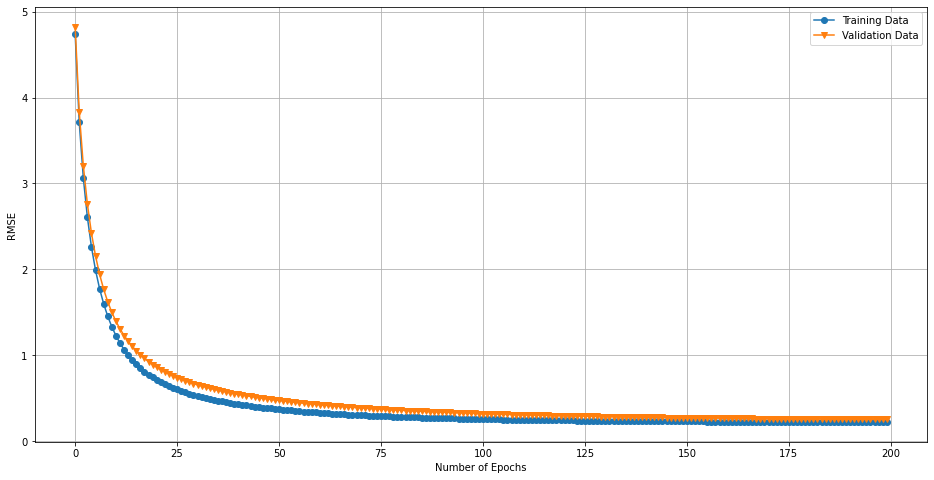

In [177]:
plt.figure(figsize=(16,8))
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Making Recommendations

In [205]:
user_id = 83
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [206]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
    artist_recommendations = artists_df[artists_df.artID.isin(top_n_artists.artistId)].reset_index(drop=True)
    artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
    return artist_recommendations.sort_values("rating", ascending=False)

In [207]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(df, existing_ratings_index, existing_ratings)

,name,url,pictureURL,artID,rating
0,Madonna,http://www.last.fm/music/Madonna,http://userserve-ak.last.fm/serve/252/340387.jpg,61,0.962121
1,Leona Lewis,http://www.last.fm/music/Leona+Lewis,http://userserve-ak.last.fm/serve/252/45104681...,288,0.818182
2,BeyoncÃ©,http://www.last.fm/music/Beyonc%C3%A9,http://userserve-ak.last.fm/serve/252/61958009...,289,0.689394
3,P!nk,http://www.last.fm/music/P%21nk,http://userserve-ak.last.fm/serve/252/56011579...,296,0.681818
4,Nelly Furtado,http://www.last.fm/music/Nelly+Furtado,http://userserve-ak.last.fm/serve/252/327744.jpg,304,0.613636
5,Justin Timberlake,http://www.last.fm/music/Justin+Timberlake,http://userserve-ak.last.fm/serve/252/10351161...,323,0.575758
6,Jessica Simpson,http://www.last.fm/music/Jessica+Simpson,http://userserve-ak.last.fm/serve/252/44836897...,459,0.545455
7,Gwen Stefani,http://www.last.fm/music/Gwen+Stefani,http://userserve-ak.last.fm/serve/252/8516439.jpg,519,0.500000
8,Sophie Ellis-Bextor,http://www.last.fm/music/Sophie+Ellis-Bextor,http://userserve-ak.last.fm/serve/252/61811325...,529,0.469697
9,MÃ³nica Naranjo,http://www.last.fm/music/M%C3%B3nica+Naranjo,http://userserve-ak.last.fm/serve/252/59412813...,2375,0.462121


In [208]:
create_artist_ratings(df, predictions_index, rating_predictions)

,name,url,pictureURL,artID,rating
0,Dan Seals,http://www.last.fm/music/Dan+Seals,http://userserve-ak.last.fm/serve/252/7498167.jpg,3547,0.969666
1,Amanda Woodward,http://www.last.fm/music/Amanda+Woodward,http://userserve-ak.last.fm/serve/252/27978343...,6693,0.956308
2,Sandy Leah - www.cdlivre.com,http://www.last.fm/music/Sandy+Leah+-+www.cdli...,NaN,12196,0.950499
3,Modern Witch,http://www.last.fm/music/Modern+Witch,http://userserve-ak.last.fm/serve/252/48243367...,12686,0.946576
4,Dwight Yoakam,http://www.last.fm/music/Dwight+Yoakam,http://userserve-ak.last.fm/serve/252/27083157...,13870,0.944214
5,ÐŸÐŸÐŸ,http://www.last.fm/music/%D0%9F%D0%9F%D0%9F,NaN,16323,0.942941
6,The Trammps,http://www.last.fm/music/The+Trammps,http://userserve-ak.last.fm/serve/252/777780.jpg,16580,0.941572
7,Moonlight Ransom,http://www.last.fm/music/Moonlight+Ransom,NaN,16772,0.939947
8,Sheryl Nome / Ranka Lee,http://www.last.fm/music/Sheryl%2BNome%2B%252F...,http://userserve-ak.last.fm/serve/252/10455149...,16798,0.933606
9,Gangrena Gasosa,http://www.last.fm/music/Gangrena+Gasosa,http://userserve-ak.last.fm/serve/252/4310871.jpg,16831,0.932547


Let's run a similar evaluation process over our second alternate method. We will look at the same user ID of 83 and look at the recommendations it makes.

In [209]:
played[played['userID'] == 83]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
1975,Madonna,http://www.last.fm/music/Madonna,61,83,61,108,0.818182,0.000303
5374,Enrique Iglesias,http://www.last.fm/music/Enrique+Iglesias,155,83,155,26,0.196970,0.000071
11971,Mariah Carey,http://www.last.fm/music/Mariah+Carey,251,83,251,25,0.189394,0.000068
12293,CÃ©line Dion,http://www.last.fm/music/C%C3%A9line+Dion,259,83,259,34,0.257576,0.000094
12593,Janet Jackson,http://www.last.fm/music/Janet+Jackson,279,83,279,85,0.643939,0.000238
12715,Rihanna,http://www.last.fm/music/Rihanna,282,83,282,20,0.151515,0.000054
13199,Britney Spears,http://www.last.fm/music/Britney+Spears,283,83,283,101,0.765152,0.000284
14065,Christina Aguilera,http://www.last.fm/music/Christina+Aguilera,286,83,286,132,1.000000,0.000371
14588,Leona Lewis,http://www.last.fm/music/Leona+Lewis,288,83,288,76,0.575758,0.000213
14758,BeyoncÃ©,http://www.last.fm/music/Beyonc%C3%A9,289,83,289,127,0.962121,0.000357


In [210]:
pre = create_artist_ratings(df, predictions_index, rating_predictions)
zzzz2 = pd.merge(pre, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [212]:
zzzz2['tagValue'].value_counts()

indie                               3
alternative                         2
rock                                1
breakup music                       1
experimental hip-hop                1
abstract hip-hop                    1
russian                             1
the spill canvas                    1
music that reminds me of friends    1
love songs                          1
kickass                             1
alternative rock                    1
country pop                         1
awesome                             1
acoustic                            1
indie rock                          1
check                               1
Name: tagValue, dtype: int64

We can see again that our system appears to be recommending artists of popular genres / tags more so and not making relevant recommendations. It is good that it is making novel recommendations on one hand and giving the user a wider scope of music. However, it must be said it would be more advisable if it could make recommendations more similar to what a user listens to identifying less popular artists of similar genres that they may have missed. This recommender like our neural network recommender appears to be suffering from the "cold start" problem many recommenders encounter.

# Spotify Recommender system

In [183]:
import tekore as tk

In [184]:
client_id = 'cb3a434dfacd4fd6b0a65dc5f4f1bd2e'
client_secret = '39d56bef066c421f9e9ebc2bc0059ebc'

In [185]:
redirect_url = 'http://ca4015.com/callback/'

In [186]:
#conf = (client_id, client_secret, redirect_uri)
#token = tk.prompt_for_user_token(*conf, scope = tk.scope.every)

#spotify = tk.Spotify(token)

In [187]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
#client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
#sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [188]:
'''
username = 'kiansweeney11'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
'''

'\nusername = \'kiansweeney11\'\nclient_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) \nsp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)\nscope = \'user-top-read\'\ntoken = util.prompt_for_user_token(username, scope)\n\nif token:\n    sp = spotipy.Spotify(auth=token)\nelse:\n    print("Can\'t get token for", username)\n'

In [189]:
'''
artist_name = []
track_name = []
popularity = []
track_id = []
results = sp.current_user_top_tracks(limit=5,offset=0,time_range='medium_term')
for i, t in enumerate(track_results['tracks']['items']):
    artist_name.append(t['artists'][0]['name'])
    track_name.append(t['name'])
    track_id.append(t['id'])
    popularity.append(t['popularity'])
'''

"\nartist_name = []\ntrack_name = []\npopularity = []\ntrack_id = []\nresults = sp.current_user_top_tracks(limit=5,offset=0,time_range='medium_term')\nfor i, t in enumerate(track_results['tracks']['items']):\n    artist_name.append(t['artists'][0]['name'])\n    track_name.append(t['name'])\n    track_id.append(t['id'])\n    popularity.append(t['popularity'])\n"

In [190]:
'''
track_dataframe = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'popularity' : popularity})
print(track_dataframe.shape)
track_dataframe.head(10)
'''

"\ntrack_dataframe = pd.DataFrame({'artist_name' : artist_name, 'track_name' : track_name, 'track_id' : track_id, 'popularity' : popularity})\nprint(track_dataframe.shape)\ntrack_dataframe.head(10)\n"

# Evaluation

We will now try to evaluate our results and methods attempted so far. I will look at using methods such as Recall, Precision, Coverage and F1 to validate our methods. I feel methods such as mean absolute error (MAE) and root mean square error (RMSE) are not suitable to our data provided. These look at the difference between the actual and predicted values, which are not really applicable to the data here. The predicted artist could be number 1 and the actual artist could be 2 and this would appear as a very good result using this method. However, the difference in genres and similarity of artist could be completely different and hence the result is misleading. We will look to implement evaluation using the "LightFM" python library.

In [191]:
import implicit
from tqdm import tqdm_notebook as tqdm
import matplotlib.ticker as ticker
from matplotlib import rc
from pandas.api.types import CategoricalDtype
import string
import re
import random
import math
from math import sqrt
from math import log
from collections import Counter, defaultdict
from operator import itemgetter
from pylab import rcParams
from pylab import savefig

In [192]:
# Create sparse matrix from dataframe object
def create_sparse_matrix(data):
  #get unique user ids and unique artist ids
  users = list(np.sort(data.userID.unique()))
  artists = list(data.artistID.unique())
  plays = list(data.playedUserNorm)

  cat_type = CategoricalDtype(categories=users, ordered=True)
  rows = data.userID.astype(cat_type).cat.codes

  cat_type = CategoricalDtype(categories=artists, ordered=True)
  cols = data.artistID.astype(cat_type).cat.codes
  # we get the rows (user ids) and columns (artist ids) and populate them using plays
  plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))
  return plays_sparse

In [193]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
  matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
  num_plays = len(M.nonzero()[0]) # Number of times any artist has been interacted with
  sparsity = 100 * (1 - float(num_plays / matrix_size))
  return sparsity

In [194]:
def evaluate_lightfm(model, original, train, test, user_features=None, item_features=None, n_rec = 20):
    print("Evaluating LightFM...")
    print("Calculating Coverage...")
    catalog = []
    for user in tqdm(range(0, original.shape[0])):
      #get scores for this particular user for all artists
      rec_scores = model.predict(user,np.arange(original.shape[1]),user_features=user_features, item_features=item_features)
      #get top k items to recommend
      rec_items = (-rec_scores).argsort()[:20]
      #calculate coverage
      #coverage calculation
      for recs in rec_items:
        if recs not in catalog:
          catalog.append(recs)
            
    coverage = len(catalog)/float(original.shape[1])
    print("Calculating Recall at k...")
    recall = recall_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    print("Calculating Precision at k...")
    precision = precision_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    f1 = (2 * precision * recall) / (precision + recall)
    return coverage, precision, recall, f1

In [195]:
playedx = played[['userID','artistID', 'playedUserNorm']]
playedx.columns = ['userID','artistID', 'playedUserNorm']

#create sparse matrix
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72171848800758
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_27724/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 11.672842502593994 %
Recall: 6.873805443414252 %
Coverage: 0.7429673321234119 %
F1: 8.652436663274997 %


In [197]:
# Create sparse matrix from dataframe object
def create_sparse_matrix(data):
  #get unique user ids and unique artist ids
  users = list(np.sort(data.userID.unique()))
  artists = list(data.artistID.unique())
  plays = list(data.playCountScaled)

  cat_type = CategoricalDtype(categories=users, ordered=True)
  rows = data.userID.astype(cat_type).cat.codes

  cat_type = CategoricalDtype(categories=artists, ordered=True)
  cols = data.artistID.astype(cat_type).cat.codes
  # we get the rows (user ids) and columns (artist ids) and populate them using plays
  plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))
  return plays_sparse

In [198]:
playedx = played[['userID','artistID', 'playCountScaled']]
playedx.columns = ['userID','artistID', 'playCountScaled']

#create sparse matrix
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72362497745786
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_27724/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 12.152300029993057 %
Recall: 7.118826218198038 %
Coverage: 0.7883393829401089 %
F1: 8.978210297703148 %


Our chosen accuracy when normalising with each user's max score is better than our play count scaled metric.

# Clustering